In [46]:
import pandas as pd
import numpy as np
import os
import gensim.downloader as api
from gensim.models import KeyedVectors
from collections import Counter
from nltk.corpus import stopwords
import nltk
import time
from numpy.core.memmap import ndarray
from sklearn.metrics import accuracy_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from skmultilearn.adapt import MLkNN
from sklearn import svm

In [2]:
import warnings
warnings.filterwarnings("ignore")
pd.set_option('display.max_colwidth', None)

In [3]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/giulia/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

## **Loading a word embedding (WE) model**
For this project the [Word2Vec](https://code.google.com/archive/p/word2vec/) pre-trained word embedding has been choosen. It consists of about 100 billion words translated into 300-dimensional vectors for 3 million words and phrases from the Google News dataset.

In [4]:
path = 'word_vectors2.kv'
if os.path.exists(path):
    word_vectors = KeyedVectors.load(path)
else:
    #model = api.load("glove-twitter-25")
    model = api.load('word2vec-google-news-300')
    word_vectors = model.wv
    word_vectors.save(path)

## **Calculating word-to-word similarities**
The selected source words are the following: <b>Paris, magic, food, sleep, elegant. </b><br> We created a dictionary with <b>source words as keys</b> and 6 <b>tuples consisting of target word and rank as values</b>. The range of our personal classification goes from 1 (most related) to 6 (least related). As a rule of thumb, we tried to keep the ratio between this two antipodes to 50/50. <br>
<style type="text/css">
.tg  {border-collapse:collapse;border-color:#9ABAD9;border-spacing:0;}
.tg td{background-color:#EBF5FF;border-color:#9ABAD9;border-style:solid;border-width:0px;color:#444;
  font-family:Arial, sans-serif;font-size:14px;overflow:hidden;padding:10px 5px;word-break:normal;}
.tg th{background-color:#409cff;border-color:#9ABAD9;border-style:solid;border-width:0px;color:#fff;
  font-family:Arial, sans-serif;font-size:14px;font-weight:normal;overflow:hidden;padding:10px 5px;word-break:normal;}
.tg .tg-0pky{border-color:inherit;text-align:left;vertical-align:top}
</style>
<table class="tg">
<thead>
  <tr>
    <th class="tg-0pky">source words&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;            </th>
    <th class="tg-0pky">target words<br>+<br>human ranking  &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;         </th>
  </tr>
</thead>
<tbody>
  <tr>
    <td class="tg-0pky">Paris</td>
    <td class="tg-0pky">1. France<br>2. croissant<br>3. Rome<br>4. civilization<br>5. sand<br>6. orthodontist</td>
  </tr>
  <tr>
    <td class="tg-0pky">magic</td>
    <td class="tg-0pky">1. illusion<br>2. black<br>3. rabbit<br>4.nice<br>5. rice<br>6. sad</td>
  </tr>
  <tr>
    <td class="tg-0pky">food</td>
    <td class="tg-0pky">1. pizza<br>2. water<br>3. hot<br>4. bar<br>5. happy<br>6. machine</td>
  </tr>
  <tr>
    <td class="tg-0pky">sleep</td>
    <td class="tg-0pky">1. night<br>2. nightmare<br>3. pillow<br>4. brother<br>5. broken<br>6. rave</td>
  </tr>
  <tr>
    <td class="tg-0pky">elegant</td>
    <td class="tg-0pky">1. suit<br>2. princess<br>3. funny<br>4. math<br>5. tattoo<br>6. alligator</td>
  </tr>
</tbody>
</table>

**Implementation**<br><br>
The function `cos_sim` takes as argument two vectors `a, b` and calculates their normalized dot product according to the formula:<br><br>
$$ \bf \text{cos}(x,y) = \frac{a}{\lVert a \rVert _2} \cdot \frac{b^T}{\lVert b \rVert _2} $$


In [5]:
def cos_sim(a, b):
    dot_product = np.matmul(a, b.T)
    norm_a = np.linalg.norm(a) 
    norm_b = np.linalg.norm(b)
    ret_val = dot_product / (norm_a * norm_b)
    return ret_val

So, for example, the vectors designated for "Italy" and "pizza" show to have a cosine similarity of ~0.16

In [6]:
italy = word_vectors.get_vector("italy")
pizza = word_vectors.get_vector("pizza")
cos_sim(pizza,italy)


0.15924986

In [7]:
source_words = ["paris", "magic", "food", "sleep", "elegant"]
words_ = {"paris": [("france",1), ("croissant", 2), ("civilization",4), ("orthodontist",6), ("rome", 3), ("sand", 5) ], #tuple (word, rank)
               "magic": [("rabbit",3), ("black",2), ("nice",4), ("rice",5), ("illusion",1), ("sad",6)], 
               "food": [("pizza",1), ("bar",4),( "machine",6), ("water",2), ("happy",5), ("hot",3)], 
               "sleep": [("brother",4), ("rave",6), ("pillow",3), ("night",1),( "nightmare",2), ("broken",5)], 
               "elegant": [("alligator",6), ("princess",2),( "suit",1), ("tattoo",5), ("funny",3), ("mathematics",4)] } 

**Reporting and observations**

In the following we display a set of five tables, each of which displays the cosine similarity computed with the function hereabove implemented and our human ranking on the right. In all cases but one the first three most similar words corresponds with words ranked in the first three places, just in slightly different order. Overall the cosine similarity reflects the expectation, and the only anomaly concern the word <b>"magic"</b>: in our expectation this word had a better relationship with the adjective <b>"black"</b>, but considering the source of the embeddings, namely, Google News, this is not surprising: it is quite rare to find article about black magic, in daily news, in 2022. It is worth noticing that among all source/target words, the maximum value reached is <b>~0.55</b> between <b>"Paris" and "France"</b>, as we expected a much higher value.

In [8]:
for key, value in words_.items():
    key_v = word_vectors.get_vector(key)
    comp_results = pd.DataFrame(columns = ['__']+[key,"human rank"])

    for word in value:
        t = cos_sim(key_v,word_vectors.get_vector(word[0])) 
        comp_results.loc[len(comp_results)] = [word[0],t, word[1]]

    comp_results = comp_results.sort_values(key, ascending=False)

    display(comp_results)
    print("\n")



,__,paris,human rank
0,france,0.555080,1
4,rome,0.546584,3
1,croissant,0.299126,2
5,sand,0.159037,5
2,civilization,0.110888,4
3,orthodontist,0.079406,6


,__,magic,human rank
4,illusion,0.366176,1
0,rabbit,0.251940,3
2,nice,0.218269,4
1,black,0.171964,2
5,sad,0.136849,6
3,rice,0.063786,5


,__,food,human rank
0,pizza,0.443432,1
3,water,0.395679,2
5,hot,0.185422,3
1,bar,0.181046,4
4,happy,0.055477,5
2,machine,0.003741,6


,__,sleep,human rank
2,pillow,0.366484,3
3,night,0.285409,1
4,nightmare,0.120137,2
1,rave,0.108205,6
0,brother,0.103987,4
5,broken,0.043387,5


,__,elegant,human rank
4,funny,0.238420,3
1,princess,0.217093,2
2,suit,0.131944,1
0,alligator,0.126078,6
5,mathematics,0.067425,4
3,tattoo,0.028919,5


# **Calculating nearest neighbors**
In this phase, we retrieve the  𝑘=10  nearest neighbors using the word embedding model.<br><br>
<b>Efficiency </b><br><br>
To ensure a efficient calculation of the dot product we refashion the input via `np.newaxis` function: <br>
First we define the numerator dot product operation; <i>" the denominator p1 can be read like: make the vector vertical (:) and add a column dimension and p2 can be read like: add a row dimension, make the vector horizontal. This operation for p2 in theory is not necessary because p2 was already horizontal"$^1$ <br><br> <small>$^1$[source](https://towardsdatascience.com/cosine-similarity-matrix-using-broadcasting-in-python-2b1998ab3ff3)</i> </small>

In [9]:
def csm(A:ndarray,B:ndarray)->float: 
    dot_product=np.matmul(A,B.T)
    p1= np.linalg.norm(A)#np.sqrt(np.sum(A**2,axis=1))[:,np.newaxis]
    p2=np.sqrt(np.sum(B**2,axis=1))[np.newaxis,:]
    ret_val = dot_product/(p1*p2)
    return ret_val[0]


**Overall implementation**
<br><br>
the implemented function `knn` takes a source vector, a set of target vectors, and the  𝑘  parameter, and returns the  𝑘  nearest neighbors together with two similarity scores: dot product and cosine similarity (implemented via `csm` function).

In [10]:
def knn(source,target,k=10):  
    r = csm(source, target)

    cos_sim =np.argsort(r)[::-1]
    dot = source @ target.T

    index_dot = np.argsort(dot)[::-1]

    return {"dot product":{"order": index_dot[0:k], "value": sorted(dot, reverse=True)[0:k]}, "cosin":{"order": cos_sim[0:k], "value": sorted(r, reverse = True)[0:k]} }

**Reporting and observations**<br><br>
In the following it is shown a table for each source word, the <b>rows</b> display:<br><br>
-the rank order of target words produced by the metrics <b>[order]</b><br>
-the similarity value of target words<b> [value]</b><br>
-the target words <b>[words]</b><br><br>
while the two <b>columns</b> concern respectively the dot product and the cosine similarity measures.<br>
Not surprisingly we notice almosta a 1:1 correspondence in the outcome of the two measures. This is probably due to the fact that dot product, if normalized, actually corresponds to cosine similarity (this also explain why dot product has a wider output range than cosine similarity). The differences, to be found only in the case of the word <b>"elegant"</b>, can be explained by the observation that being <b>the only adjective</b> it is more versatile, i.e. it can be tied to a different selection of nouns, whereas nouns and verbs have a more pronounced semantic belonging between themselves. From a mathematical point of view, it can also be that differences depend by the fact that dot product takes into account the <b>lenghts and occurrences</b> of words, whereas cosine similarity is not magnitude sensitive.

In [11]:
for key, value in words_.items():
    target = []
    key_v = word_vectors.get_vector(key) #wv
    for i in value:
        value_v = word_vectors.get_vector(i[0])
        target.append(value_v)

    target = np.array(target)
    ret_val =knn(key_v,target )
    words_c = []
    for j in ret_val["cosin"]["order"]:
        words_c.append(value[j][0])
  
    ret_val["cosin"]["words"] = words_c
  
    words_d = []
    for j in ret_val["dot product"]["order"]:
        words_d.append(value[j][0])
  
    ret_val["dot product"]["words"] = words_d

    df = pd.DataFrame.from_dict(ret_val)

    print("key: ", key)
    display(df)


    print("\n\n\n")

  

key:  paris


,dot product,cosin
order,"[0, 4, 1, 5, 2, 3]","[0, 4, 1, 5, 2, 3]"
value,"[6.7056293, 5.128788, 3.4958282, 1.5757673, 1.2555757, 0.97523594]","[0.5550795, 0.5465838, 0.29912594, 0.1590366, 0.11088846, 0.07940605]"
words,"[france, rome, croissant, sand, civilization, orthodontist]","[france, rome, croissant, sand, civilization, orthodontist]"






key:  magic


,dot product,cosin
order,"[4, 0, 2, 1, 5, 3]","[4, 0, 2, 1, 5, 3]"
value,"[3.170901, 2.0277839, 1.7034643, 1.2302322, 1.1537026, 0.6292146]","[0.36617595, 0.25194007, 0.2182694, 0.17196375, 0.13684875, 0.063786276]"
words,"[illusion, rabbit, nice, black, sad, rice]","[illusion, rabbit, nice, black, sad, rice]"






key:  food


,dot product,cosin
order,"[0, 3, 5, 1, 4, 2]","[0, 3, 5, 1, 4, 2]"
value,"[3.7765813, 2.7387886, 1.3421888, 1.2980336, 0.36545038, 0.026318029]","[0.44343227, 0.39567885, 0.1854218, 0.1810458, 0.055477098, 0.0037409926]"
words,"[pizza, water, hot, bar, happy, machine]","[pizza, water, hot, bar, happy, machine]"






key:  sleep


,dot product,cosin
order,"[2, 3, 4, 1, 0, 5]","[2, 3, 4, 1, 0, 5]"
value,"[3.830201, 1.9355688, 1.18206, 1.0496868, 0.90746963, 0.38045508]","[0.36648425, 0.28540924, 0.12013676, 0.10820493, 0.10398727, 0.0433865]"
words,"[pillow, night, nightmare, rave, brother, broken]","[pillow, night, nightmare, rave, brother, broken]"






key:  elegant


,dot product,cosin
order,"[1, 4, 0, 2, 5, 3]","[4, 1, 2, 0, 5, 3]"
value,"[2.0062206, 1.8845644, 1.3815546, 1.0915424, 0.57979035, 0.3136271]","[0.23842005, 0.21709342, 0.13194413, 0.12607822, 0.067424625, 0.028918523]"
words,"[princess, funny, alligator, suit, mathematics, tattoo]","[funny, princess, suit, alligator, mathematics, tattoo]"


# CLASSIFICATION WITH WORD EMBEDDING


First thing first, we retrieve and use the same code of Assignment 1 to preprocess the three datasets and get our bag of words.

In [12]:
start = time.time()
def cleaning_pipeline(df):
    e_stopwords = stopwords.words('english')
    train_list = df["text"].values.tolist()
    words_without_stopw = []
    for sentence in train_list:
        temp = []
        for word in sentence.lower().split():
            if word not in e_stopwords and  word.isalpha():
                temp.append(word)
        words_without_stopw.append(temp)
    ret_df = pd.DataFrame({"raw_words": words_without_stopw, "label": df.label.values})
    return ret_df

def get_boW(l_of_words,k=100):
    words = set()
    for i in l_of_words:
        counter = Counter(i).most_common(k)
        words.update([i[0] for i in counter])
    return words
#------------------------------------------------------------#
SPLITS = ['train', 'test', "validation"]
datasets = { }

#Load the train, validation, and test sets.
path = "nlp2022_23_data/thedeep.subset.{}.txt"
csv_header = ['idx', 'text', 'label']
for split in SPLITS:
        datasets[split] = {}
        datasets[split]['df'] = cleaning_pipeline(pd.read_csv(path.format(split), names = csv_header))

words = get_boW(datasets["train"]["df"]["raw_words"].values)
end = time.time()
print(end - start)

2.8455801010131836


**Map word embeddings to dictionary words**<br><br>
For every word in the dictionary we recover the corresponding word embedding from the pre-trained model. <b>In 6871 instances (~31.7%) there was no match</b>, so the missing word-vector has been randomly initialized with values between the minimum and maximum in the word embedding.

In [13]:
dict_ = {}
count = 0
temp = []
min_ = 0
max_ = 0
for word in list(words):
    try:
        embedd_w = word_vectors.get_vector(word)
        if min(embedd_w) < min_:
            min_ = min(embedd_w)
        if max(embedd_w) > max_:
            max_ = max(embedd_w)
        dict_[word] = embedd_w
    
    except:
        temp.append(word)
        count += 1

for word in temp:
    dict_[word] = np.random.uniform(min_, max_, 300) 

   
print(f'missing word-vector representations: {count}')

missing word-vector representations: 6871


**Document embedding as the average of word embeddings**<br>
In the following we implemented the function `doc_representation` which takes as input:<br> `df`: a dataframe containing the 21689 documents;<br>`words`: a list of words to fetch the corresponding vector representation. By iterating over them it produces a representation of the whole document space based on the mean of word embeddings, as described thereunder:

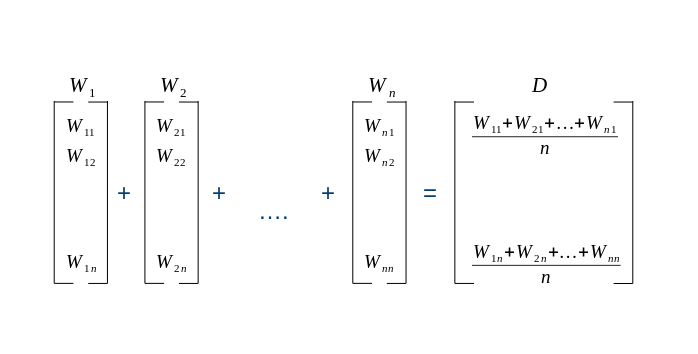

In [14]:
def doc_representation(df,words):
    d = df["raw_words"].values.tolist() 
    doc_repr = [] 
    for i in d:
        single_doc = []
        w = words.intersection(i) 
        
        for word in w:           
            single_doc.append(dict_.get(word))
        
        
        if len(w) > 0:
            
            single_doc = np.mean(single_doc, axis=0)
            doc_repr.append(single_doc)
        else:
            doc_repr.append(np.repeat(0, 300))
    ret_df = pd.DataFrame()
    ret_df["representation"] = doc_repr
    ret_df["label"] = df["label"]  
    return ret_df

In [15]:
start = time.time()
for split in SPLITS:
    datasets[split]["embeddings"] = doc_representation(datasets[split]["df"],words) 
end = time.time()
print(end - start)

0.6124680042266846


## **Classification and evaluation**
We applied four* classification algorithms which are best suited for a multilabe classification task, i.e.:<br><br><b>
-K-nearest neighbors algorithm (k-NN)<br>
-Random Forest (RF)<br>
-Multi Layer Perceptron (MLP)<br>
-Singular Value Decomposition (SVD)<br><br></b>
We first used the validation set to find the optimal hyperparameters, then deployed the models on the test set.
It is worth mentioning that a previous version of this project use the embedding of GloVe Twitter, but we choose to change it since the one actually utilized hel way higher accuracy.<br><br>
<i>*not three because we suspect something went wrong with MLP since it helds the same accuracy for very different hyperparameters</i>

### K-nearest neighbors algorithm (k-NN)
**Validation set**<br>
After an initial choiche of hyperparameter in the range 5 to 100 we downsized the best choices between 20 and 30 neighbours. <br>One of the best choiche is 22.

In [16]:
neighbours = [20, 22, 25, 27, 30]

for nn in neighbours:
    
    model = KNeighborsClassifier(n_neighbors=nn) 
    y = datasets["train"]["embeddings"]["label"].values.tolist()
    X_train = datasets["train"]["embeddings"]["representation"].values.tolist()
    
    model = model.fit(X_train, y)
    
    X_validation = datasets["validation"]["embeddings"]["representation"].values.tolist()
    y_pred = model.predict(X_validation)
    y_true = datasets["validation"]["embeddings"]["label"].values.tolist()
    
    acc= accuracy_score(y_true, y_pred)
    print(f"accuracy of KNN with {nn} neighbours on validation set: {acc}")

accuracy of KNN with 20 neighbours on validation set: 0.6590909090909091
accuracy of KNN with 22 neighbours on validation set: 0.6610169491525424
accuracy of KNN with 25 neighbours on validation set: 0.6579352850539292
accuracy of KNN with 27 neighbours on validation set: 0.6544684129429892
accuracy of KNN with 30 neighbours on validation set: 0.6536979969183359


**Test set**

In [17]:
model = KNeighborsClassifier(n_neighbors=22)
y = datasets["train"]["embeddings"]["label"].values.tolist()
X_train = datasets["train"]["embeddings"]["representation"].values.tolist()

model = model.fit(X_train, y)

X_test = datasets["test"]["embeddings"]["representation"].values.tolist()
y_pred = model.predict(X_test)
y_true = datasets["test"]["embeddings"]["label"].values.tolist()
    
acc = accuracy_score(y_true, y_pred)
print(f"accuracy of NKK on test-set: {acc}")

accuracy of NKK on test-set: 0.6716763005780347


### Random Forest
**Validation set**<br>
Best parameter for number of estimator: 200

In [18]:
estimators= [35, 55, 70, 100, 200]

for num in estimators:
    
    model = RandomForestClassifier(n_estimators= num)
    y = datasets["train"]["embeddings"]["label"].values.tolist()
    X_train = datasets["train"]["embeddings"]["representation"].values.tolist()
    
    model = model.fit(X_train, y)
    
    X_validation = datasets["validation"]["embeddings"]["representation"].values.tolist()
    y_pred = model.predict(X_validation)
    y_true = datasets["validation"]["embeddings"]["label"].values.tolist()
    
    acc = accuracy_score(y_true, y_pred)
    print(f"accuracy of Random Forest with {num} estimators on validation set: {acc}")

accuracy of Random Forest with 35 estimators on validation set: 0.6047765793528506
accuracy of Random Forest with 55 estimators on validation set: 0.6221109399075501
accuracy of Random Forest with 70 estimators on validation set: 0.6224961479198767
accuracy of Random Forest with 100 estimators on validation set: 0.6251926040061633
accuracy of Random Forest with 200 estimators on validation set: 0.6336671802773498


**Test set**

In [28]:
model = RandomForestClassifier(n_estimators=100)
y = datasets["train"]["embeddings"]["label"].values.tolist()
X_train = datasets["train"]["embeddings"]["representation"].values.tolist()

model = model.fit(X_train, y)

X_test = datasets["test"]["embeddings"]["representation"].values.tolist()
y_pred = model.predict(X_test)
y_true = datasets["test"]["embeddings"]["label"].values.tolist()
    
acc = accuracy_score(y_true, y_pred)
print(f"accuracy of Random Forest on test-set: {acc}")

accuracy of Random Forest on test-set: 0.6385356454720617


### Multi-Layer Perceptron
**Validation set**<br>
Increasing the number of hidden layers showed to be not as useful as increasing the number of neurons. <br>
All parameters seems to held the same accuracy, furthermore the accuracy on the test-set is suspiciously higher than on validation set, hinting a case of overfitting.

In [20]:
layer_size= [(25,50), (25,), (50,), (100,), (300,), (1000,)]

for num in layer_size:
    
    model = MLPClassifier(hidden_layer_sizes= num)
    y = datasets["train"]["embeddings"]["label"].values.tolist()
    X_train = datasets["train"]["embeddings"]["representation"].values.tolist()
    
    model = model.fit(X_train, y)
    
    X_validation = datasets["validation"]["embeddings"]["representation"].values.tolist()
    y_pred = model.predict(X_validation)
    y_true = datasets["validation"]["embeddings"]["label"].values.tolist()
    
    acc_ = accuracy_score(y_true, y_pred)
    print(f"accuracy of Multi Layer Perceptron with {num} hidden units on validation set: {acc}")


accuracy of Multi Layer Perceptron with (25, 50) hidden units on validation set: 0.6458574181117533
accuracy of Multi Layer Perceptron with (25,) hidden units on validation set: 0.6458574181117533
accuracy of Multi Layer Perceptron with (50,) hidden units on validation set: 0.6458574181117533
accuracy of Multi Layer Perceptron with (100,) hidden units on validation set: 0.6458574181117533
accuracy of Multi Layer Perceptron with (300,) hidden units on validation set: 0.6458574181117533
accuracy of Multi Layer Perceptron with (1000,) hidden units on validation set: 0.6458574181117533


**Test set**

In [21]:
model = MLPClassifier(hidden_layer_sizes= num)
y = datasets["train"]["embeddings"]["label"].values.tolist()
X_train = datasets["train"]["embeddings"]["representation"].values.tolist()

model = model.fit(X_train, y)

X_test = datasets["test"]["embeddings"]["representation"].values.tolist()
y_pred = model.predict(X_test)
y_true = datasets["test"]["embeddings"]["label"].values.tolist()
    
acc = accuracy_score(y_true, y_pred)
print(f"accuracy of Multi Layer Perceptron on test-set: {acc}")

accuracy of Multi Layer Perceptron on test-set: 0.7526011560693642


### Singular Value Decomposition (SVD)
**Validation set**<br>
Assignment 1 revealed an imbalance in the data, therefore SVD was implemented with higher weights for the classes less represented.

In [42]:
c_weights = {0:.2, 2:.1, 3:.1, 4:.0, 5:0, 6:.2, 7:.2, 8:.1, 9:0, 10:.0, 11:.0}

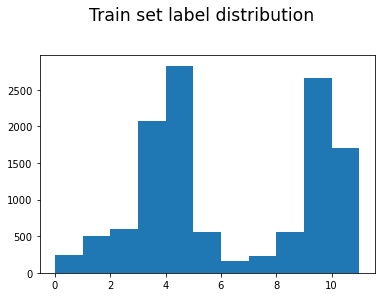

In [49]:
model= svm.SVC(class_weight=c_weights)
y = datasets["train"]["embeddings"]["label"].values.tolist()
X_train = datasets["train"]["embeddings"]["representation"].values.tolist()

model = model.fit(X_train, y)

X_validation = datasets["test"]["embeddings"]["representation"].values.tolist()
y_pred = model.predict(X_validation)
y_true = datasets["test"]["embeddings"]["label"].values.tolist()

acc_ = accuracy_score(y_true, y_pred)
print(f"accuracy of SVD on test-set: {acc}")

accuracy of SVD on test-set: 0.6385356454720617
